### Setup

In [11]:
SAMPLE   = "2016MagUp"
VRS_MUON   = "v1.1.bc.r.tb"
VRS_PROTON = "v1.1.bc.r.tb"

chunk_size  = None
reweighting = True

In [12]:
import os
import yaml
import pickle
import numpy as np
import tensorflow as tf

import matplotlib.font_manager
import matplotlib.pyplot as plt
import mplhep as hep

from lb_pidsim_train.trainers import DataHandler
from lb_pidsim_train.utils    import PidsimColTransformer

In [13]:
NP_FLOAT = np.float32
TF_FLOAT = tf.float32

### Configuration files

In [14]:
with open ("../training/config/config.yaml") as file:
  config = yaml.full_load (file)

with open ("../training/config/datasets.yaml") as file:
  datasets = yaml.full_load (file)

with open ("../training/config/variables.yaml") as file:
  variables = yaml.full_load (file)

with open ("../training/config/selections.yaml") as file:
  selections = yaml.full_load (file)

### Data loading

In [15]:
dh_mu = DataHandler()
dh_p  = DataHandler()

In [16]:
data_dir = config["data_dir"]

file_list_mu = datasets["Muon"]["Muon"][SAMPLE]
file_list_mu = [ f"{data_dir}/{file_name}" for file_name in file_list_mu ]

file_list_p  = datasets["Muon"]["Proton"][SAMPLE]
file_list_p  = [ f"{data_dir}/{file_name}" for file_name in file_list_p ]

In [17]:
dh_mu . feed_from_root_files ( root_files = file_list_mu , 
                               X_vars = variables["Muon"]["X_vars"][SAMPLE] , 
                               Y_vars = variables["Muon"]["Y_vars"][SAMPLE] , 
                               w_var  = variables["Muon"]["w_vars"][SAMPLE] , 
                               selections = selections["Muon"][SAMPLE] , 
                               tree_names = None , 
                               chunk_size = chunk_size , 
                               verbose = 1 )

dh_p  . feed_from_root_files ( root_files = file_list_p , 
                               X_vars = variables["Muon"]["X_vars"][SAMPLE] , 
                               Y_vars = variables["Muon"]["Y_vars"][SAMPLE] , 
                               w_var  = variables["Muon"]["w_vars"][SAMPLE] , 
                               selections = selections["Muon"][SAMPLE] , 
                               tree_names = None , 
                               chunk_size = chunk_size , 
                               verbose = 1 )

Data-chunk of 23304101 rows correctly loaded in 34.639 s
Data-chunk of 5224971 rows correctly loaded in 12.833 s


In [18]:
dh_mu . prepare_dataset (verbose = 1)
dh_p  . prepare_dataset (verbose = 1)

Shuffle-time: 5.959 s
Shuffle-time: 0.971 s


### Preprocessing step

In [19]:
model_dir  = config["model_dir"]

model_name_mu = f"Muon_Muon_{SAMPLE}_{VRS_MUON}"
model_name_p  = f"Muon_Proton_{SAMPLE}_{VRS_PROTON}"

In [20]:
scaler_X   = list()
scaler_Y   = list()
reweighter = list()

for model_name in [model_name_mu, model_name_p]:
  
  file_X = f"{model_dir}/{model_name}/transform_X.pkl"
  scaler_X . append ( PidsimColTransformer ( pickle.load ( open (file_X, "rb") ) ) )

  file_Y = f"{model_dir}/{model_name}/transform_Y.pkl"
  scaler_Y . append ( PidsimColTransformer ( pickle.load ( open (file_Y, "rb") ) ) )

  if reweighting:
    file_w = f"{model_dir}/{model_name}/saved_reweighter"
    reweighter . append ( tf.keras.models.load_model ( file_w ) )

### Generator output

In [21]:
gen_mu = tf.keras.models.load_model ( f"{model_dir}/{model_name_mu}/saved_generator" )
gen_p  = tf.keras.models.load_model ( f"{model_dir}/{model_name_p}/saved_generator" )

In [22]:
Y_gen = list()
w_gen = list()

for i, dh, generator in zip ([0, 1], [dh_mu, dh_p], [gen_mu, gen_p]):

  batch_size = len(dh.X)
  latent_dim = generator.input_shape[1] - dh.X.shape[1]

  X_gen = scaler_X[i] . transform ( dh.X )
  X_gen = tf.convert_to_tensor ( X_gen, dtype = TF_FLOAT )
  latent_tensor = tf.random.normal ( shape = (batch_size, latent_dim), dtype = TF_FLOAT )
  input_tensor  = tf.concat ( [X_gen, latent_tensor], axis = 1 )

  gen_output = generator ( input_tensor ) . numpy() . astype (NP_FLOAT)
  Y_gen . append ( scaler_Y[i] . inverse_transform ( gen_output ) )

  if reweighting:
    w_gen . append ( reweighter[i] (X_gen) . numpy() . astype (NP_FLOAT) )
  else:
    w_gen . append ( np.copy(dh.w) . astype (NP_FLOAT) )

Y_gen_mu, Y_gen_p = Y_gen
w_gen_mu, w_gen_p = w_gen

2022-04-07 23:50:44.459652: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 5965849856 exceeds 10% of free system memory.
2022-04-07 23:50:45.324973: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 5965849856 exceeds 10% of free system memory.
2022-04-07 23:50:45.809530: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 5965849856 exceeds 10% of free system memory.
2022-04-07 23:50:47.032949: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 6338715472 exceeds 10% of free system memory.
2022-04-07 23:50:47.553915: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 11931699712 exceeds 10% of free system memory.


### Validation plots

In [23]:
plt.style.use(hep.style.LHCb2)
plt.rcParams["axes.linewidth"]    = 1.3
plt.rcParams["xtick.major.width"] = 1
plt.rcParams["ytick.major.width"] = 1
plt.rcParams["xtick.minor.width"] = 1
plt.rcParams["ytick.minor.width"] = 1
plt.rcParams["xtick.major.size"]  = 10
plt.rcParams["ytick.major.size"]  = 10
plt.rcParams["xtick.minor.size"]  = 5
plt.rcParams["ytick.minor.size"]  = 5

In [33]:
binning = np.linspace (-9, 1, 100)

h_ref_mu , bins_ref_mu = np.histogram ( dh_mu.Y[:,0]  , bins = binning , weights = dh_mu.w.flatten()  , density = True )
h_gen_mu , bins_gen_mu = np.histogram ( Y_gen_mu[:,0] , bins = binning , weights = w_gen_mu.flatten() , density = True )

h_ref_p , bins_ref_p = np.histogram ( dh_p.Y[:,0]  , bins = binning , weights = dh_p.w.flatten()  , density = True )
h_gen_p , bins_gen_p = np.histogram ( Y_gen_p[:,0] , bins = binning , weights = w_gen_p.flatten() , density = True )

y_min = min ( 1 , min ( min ( h_ref_mu[h_ref_mu>0] . min() , h_gen_mu[h_gen_mu>0] . min() ) ,
                        min ( h_ref_p[h_ref_p>0]   . min() , h_gen_p[h_gen_p>0]   . min() ) ) )
y_max = max ( max ( h_ref_mu.max() , h_gen_mu.max() ) ,
              max ( h_ref_p.max()  , h_gen_p.max()  ) )
y_max *= 15

In [34]:
img_dir  = "./images"
fig_name = f"MuonMuLL_Muon_vs_Proton_{SAMPLE}"

if not os.path.exists (img_dir): os.makedirs (img_dir)

<Figure size 700x900 with 0 Axes>

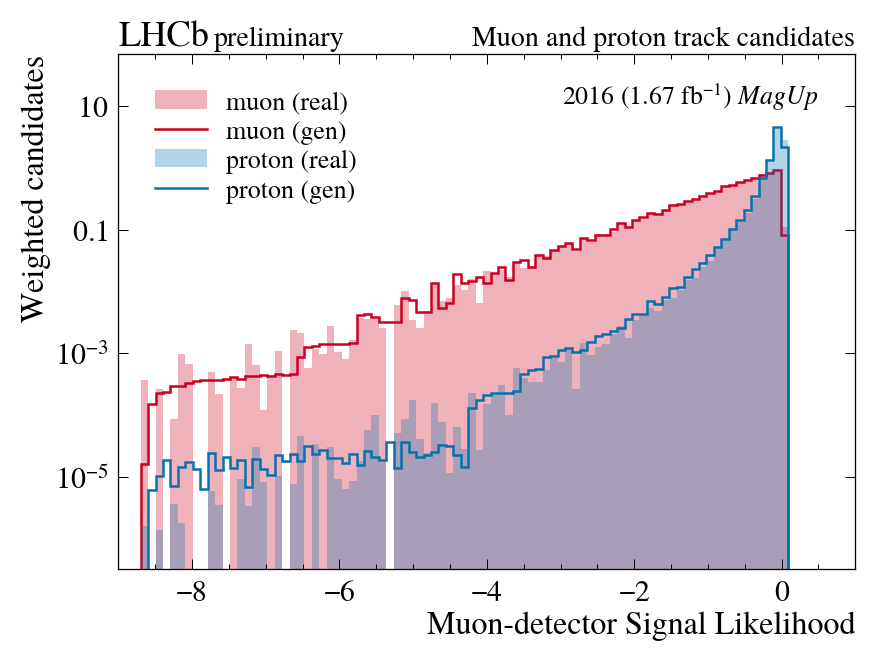

In [36]:
plt.figure (figsize = (7,9), dpi = 100)
fig, ax = plt.subplots()
ax.set_xlabel ( "Muon-detector Signal Likelihood", fontname = "serif", size = 32 )
ax.set_ylabel ( "Weighted candidates", fontname = "serif", size = 32 )

hep.histplot (h_ref_mu, bins_ref_mu, histtype = "fill", color = "#ca0020", alpha = 0.3, label = "muon (real)")
hep.histplot (h_gen_mu, bins_gen_mu, histtype = "step", color = "#ca0020", lw = 2.5, label = "muon (gen)")

hep.histplot (h_ref_p, bins_ref_p, histtype = "fill", color = "#0571b0", alpha = 0.3, label = "proton (real)")
hep.histplot (h_gen_p, bins_gen_p, histtype = "step", color = "#0571b0", lw = 2.5, label = "proton (gen)")

hep.lhcb.text("preliminary", loc = 0, fontname = "serif", fontsize = 28, italic = [False, False])
ax.annotate ( f"Muon and proton track candidates", 
              ha = "right", va = "bottom",
              xy = (0.999,1.005), xycoords = "axes fraction",
              fontname = "serif", size = 28)
ax.annotate ( r"$2016~(1.67~\rm{fb}^{-1})~\it{MagUp}$", 
              ha = "right", va = "top",
              xy = (0.95, 0.95), xycoords = "axes fraction" ,
              fontname = "serif", size = 26 )

ax.legend ( loc = "upper left", prop = {"family" : "serif", "size" : 26} )
ax.set_xlim (binning[0], binning[-1])
ax.set_ylim (y_min, y_max)

ax.set_yscale ("log")

plt.savefig (f"{img_dir}/{fig_name}.png")
plt.show()
plt.close()